## Experiement on Physics Informed Neural Network 

In this notebook, a neural network is trained to predict projecttile motion in a 2D environment. 

In this taks - 
* We input throwing velocity (initial velocity - v0), throwing angle (theta), and time. If we know the v0, and alpha, we can calulate the coordinate of an object in 2D with phyics equation. 


### Projectile Motion Equations

Given:
- \( v_0 \): initial velocity
- \( \theta \): angle of projection (in radians)
- \( g \): acceleration due to gravity (typically \( 9.8 \, \text{m/s}^2 \))
- \( t \): time

The horizontal and vertical positions of the projectile at time \( t \) are given by the following equations:

1. **Horizontal Position** \( x(t) \):

$$
x(t) = v_0 \cdot t \cdot \cos(\theta)
$$

2. **Vertical Position** \( y(t) \):

$$
y(t) = v_0 \cdot t \cdot \sin(\theta) - \frac{1}{2} g t^2
$$


In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

In [18]:
class PINNv3(nn.Module):
    def __init__(self, inp_size, out_size) -> None:
        super().__init__()
        self.layer1 = nn.Linear(inp_size, 128)
        self.norm1 = nn.LayerNorm(128)
        self.layer2 = nn.Linear(128, 64)
        self.norm2 = nn.LayerNorm(64)
        self.layer3 = nn.Linear(64, out_size)

    def forward(self, x):
        x = F.tanh(self.norm1(self.layer1(x)))
        x = F.tanh(self.norm2(self.layer2(x)))

        return self.layer3(x)

In [19]:
def get_pos(v:float, theta:float, t:float):
    """This Return the (x,y) cord for the given projectile parameter.

    Args:
        v (float): velocity in m/s^2
        theta (float): angle of  projectile in radian
        t (float): time in second

    Returns:
        x, y
    """
    x = v*np.cos(theta)*t
    y = -0.5*9.8*t**2 + v*np.sin(theta)*t

    return x, y

In [20]:
SCALE_FACTOR = 100

In [21]:
def get_sample_data():
    """Generate Sample Data

    Returns:
        [v0, theta, t] : input where v0 and t is scalled with a scale factor.
        [x, y] : output are scalled with a scale factor.
        [T] : time of flight

    """
    g = 9.8
    v0 = np.random.randint(1,110)
    theta = np.random.randint(1,91)
    theta = np.deg2rad(theta)
    
    T = 2*(v0*np.sin(theta)/g)
    # print(T, v0, theta)
    
    if T>0.1:
        t = np.random.uniform(0.1,T)
    else:
        t = T

    x, y = get_pos(v0, theta, t)
    # return torch.tensor([v0, theta, t], dtype=torch.float), torch.tensor([x,y], dtype=torch.float)
    return [v0/SCALE_FACTOR, theta, t/SCALE_FACTOR], [x/SCALE_FACTOR,y/SCALE_FACTOR], [T]

In [22]:
# inp = torch.tensor([X], dtype=torch.float)
# inp
SCALE_FACTOR = 100

In [23]:
class ProjectileData(Dataset):
    def __init__(self, data_size=1000):
        # datata generation 
        X_train = []
        Y_train = []
        T = []
        for _ in range(data_size):
            x_t, y_t, t = get_sample_data()
            X_train.append(x_t)
            Y_train.append(y_t)
            T.append(t)

        self.X_train = torch.tensor(X_train, dtype=torch.float)
        self.Y_train = torch.tensor(Y_train, dtype=torch.float)
        self.T = torch.tensor(T, dtype=torch.float)
    
    def __len__(self):
        return self.X_train.shape[0]
    
    def __getitem__(self, index):
        # return self.X_train[index]/SCALE_FACTOR, self.Y_train[index]/SCALE_FACTOR, self.T[index]
        return self.X_train[index], self.Y_train[index], self.T[index]

In [24]:
dataset = ProjectileData(data_size=7680)

In [25]:
sample_inp, sample_out, T = dataset[3]
sample_inp, sample_out, T 

(tensor([0.8600, 0.5061, 0.0425]), tensor([3.2005, 0.8869]), tensor([8.5089]))

In [26]:
x, y = get_pos(sample_inp[0]*100, sample_inp[1], sample_inp[2]*100)
x/SCALE_FACTOR, y/SCALE_FACTOR

(tensor(3.2005), tensor(0.8869))

In [27]:
train_dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
# next(iter(train_dataloader))

In [30]:
model = PINNv3(3,2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()
# loss_fn = nn.MSELoss()


model.to(device)
loss_fn.to(device)

SmoothL1Loss()

In [31]:
# training loop 
EPOCH = 10000
history  = []

for epoch in range(1, EPOCH+1):

    # set model into training mode
    
    model.train()
    running_loss = 0.0

    for i, (inp, out, _) in  enumerate(train_dataloader):
        optimizer.zero_grad()

        # dataset data
        x = inp.cuda()
        y = out.cuda()

        # forward pass and predict output
        y_ = model(x)
        # print(y_)

        # calculate loss 
        loss  = loss_fn(y, y_).float()
        
        # backprop
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        print(f"{epoch}|{EPOCH} LOSS:{running_loss/len(train_dataloader)}", end="\r")

    
    if epoch%100==0:
        print("\n")
        # mini validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            v, alpha, t = 99, 51 ,13
            alpha = np.deg2rad(alpha)
            print("Validation at", epoch)
            validation_sample = torch.tensor([v/SCALE_FACTOR, alpha, t/SCALE_FACTOR], dtype=torch.float)
            pred_y = model(validation_sample.to(device))*SCALE_FACTOR
            val_y = get_pos(v=v, theta=alpha, t=t)
            print("Input", v, np.rad2deg(alpha), t, " Output", pred_y, " Truth", val_y)
        
        # print(f"\n")

    history.append(running_loss/len(train_dataloader))


In [25]:
import matplotlib.pyplot as plt

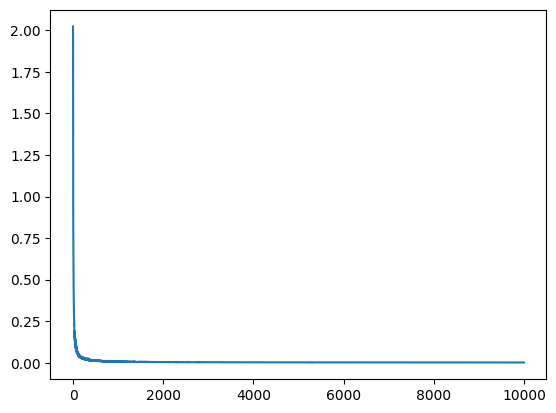

In [26]:
plt.plot(history)

In [18]:
history[-1]

0.0012403730851171227

In [28]:
model.eval()

with torch.no_grad():

    v, alpha, t = 30, 80, 2
    alpha= np.deg2rad(alpha)
    validation_sample = torch.tensor([v/100, alpha, t/100], dtype=torch.float)
    pred_y = model(validation_sample.to(device))*SCALE_FACTOR
    val_y = get_pos(v, alpha, t)
    print("Input", validation_sample, "\nOutput", pred_y, "\nTruth", val_y)

Input tensor([0.3000, 1.3963, 0.0200]) 
Output tensor([ 9.3660, 40.8383], device='cuda:0') 
Truth (10.418890660015824, 39.48846518073248)


In [21]:
import time

In [22]:
torch.save(model.state_dict(), f"checkpoint/{model._get_name()}_model_ep{EPOCH}_{int(time.time())}.pt")